# GLOVe-LSA-SVM
- Uses LSA to capture latent features
- Uses SVM to find optimal hyperplane of separation

---

**TODO**


In [12]:
## IMPORTS
# GLOVE Embeddings
import spacy

# LSA
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

# SVM
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterGrid, StratifiedKFold
import scipy.stats as stats
from joblib import parallel_backend

# GLOVE Embeddings
import spacy

# Preprocessing
import csv
import chardet
import numpy as np
import re
import pandas as pd
import demoji
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import json

# metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import seaborn as sns

# metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, balanced_accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/walnuts/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# Load the dataset / read csv
# MAKE SURE CSV IS IN UTF-8 (if tweets have emojis)

## Testing if csv can open (Use for troubleshooting)
# with open('Eng_Tweets.csv') as csv_file:
#   csvFile = csv.reader(csv_file, delimiter=',')
#   for row in csv_file:
#     print(row)

LANG = 2 # 1 = English | 2 = Tagalog
DO_GRIDSEARCH = False

pd.set_option('display.max_colwidth', None)
csv_path = 'Eng_Tweets.csv' if LANG == 1 else 'Tag_Tweets.csv'


df = pd.read_csv(csv_path)
print("total rows: " + str(len(df)))
df.head() ## head won't show emojis unless using print function

total rows: 1640


,Username,Tweet,Date posted,Label
0,@Maymay,Nung bata ako may mga ganito akong notebook na puro artista ang mukha tapos nasa isip “ano kaya pakiramdam na andyan yun mukha ko? “ Pero ngayon di ko na kailangan isipin yun.. dahil tinupad nyo ang pakiramdam na yun. Maraming salamat po Sa inyong lahat. https://t.co/DySM14tqUs,05/30/19,0.0
1,@alwaysVIRGO,"Di muna masyado makapag dutdut ngayon sobrang sama talaga pakiramdam ko, pero mag-aambag parin\r\n\r\nKAIREN TEENTASTIC https://t.co/IOYRfUt0sD",09/10/24,0.0
2,@𝐣𝐚𝐢 ˙𐃷˙ ˙˚°✰,So anong pakiramdam na may picture kayo sa cellphone ni Junkyu? 🙇🏻‍♀️ https://t.co/zygW8j3Gia,09/09/24,0.0
3,@🌷 Turon Ng SM 🌷,"panay siksik, alam naman ng masama pakiramdam ng daddy 🥴🤧😷🤒 https://t.co/UtRYLGdCms",09/10/24,0.0
4,@ₐₛₜᵣₒ,Eto yung pinaka ayaw kong pakiramdam ngayon pero wala may mood talaga tayong gusto lang natin magpahinga,09/05/24,1.0


## Preprocessing
- Remove mentions (@)
- Remove hashtags (#)
- Remove URLs
- Replace emojis with textual description (Using demoji)
- Remove stop words

In [14]:
### PREPROCESSING STEPS (FOR TAGALOG)
with open('tl_stopwords.json', 'r') as f:
    tagalog_stop_words = json.load(f)

# Preprocessing functions
def clean_text_tl(text):
    # Remove mentions
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Replace emoji with textual descriptions
    text = demoji.replace_with_desc(text)
    text = re.sub(r'(:[a-zA-Z\s]+:)', r' \1 ', text)  # Add spaces around the shortcode
    text = re.sub(r'(:[a-zA-Z\s]+:)', lambda match: match.group(0).replace(' ', '_'), text)
    text = text.strip()
    return text

def remove_stopwords_tl(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in tagalog_stop_words]
    return ' '.join(filtered_words)

In [15]:
### PREPROCESSING STEPS
def clean_text(text):
  # Remove mentions
  text = re.sub(r'@[A-Za-z0-9_]+', '', text)
  # Remove hashtags
  text = re.sub(r'#\w+', '', text)
  # Remove URLs
  text = re.sub(r'http\S+|www\S+|https\S+', '', text)
  # Replace emoji with textual descriptions
  text = demoji.replace_with_desc(text)
  text = re.sub(r'(:[a-zA-Z\s]+:)', r' \1 ', text) # Add spaces around the shortcode
  text = re.sub(r'(:[a-zA-Z\s]+:)', lambda match: match.group(0).replace(' ', '_'), text)
  text = text.strip()
  return text

stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
  words = text.split()
  filtered_words = [word for word in words if word.lower() not in stop_words]
  return ' '.join(filtered_words)

df = df.dropna() # Get rid of NaN rows

In [16]:
## Execute preprocessing
df = df.dropna()  # Get rid of NaN rows

if LANG == 1:
    print("EXECUTING TAGALOG TWEET CLEANING")
    df['Tweet'] = df['Tweet'].apply(clean_text_tl)
    df['Tweet'] = df['Tweet'].apply(remove_stopwords_tl)
else:
    print("EXECUTING ENGLISH TWEET CLEANING")
    df['Tweet'] = df['Tweet'].apply(clean_text)
    df['Tweet'] = df['Tweet'].apply(remove_stopwords)

df.head()

EXECUTING ENGLISH TWEET CLEANING


,Username,Tweet,Date posted,Label
0,@Maymay,Nung bata ako may mga ganito akong notebook na puro artista ang mukha tapos nasa isip “ano kaya pakiramdam na andyan yun mukha ko? “ Pero ngayon di ko na kailangan isipin yun.. dahil tinupad nyo ang pakiramdam na yun. Maraming salamat po Sa inyong lahat.,05/30/19,0.0
1,@alwaysVIRGO,"Di muna masyado makapag dutdut ngayon sobrang sama talaga pakiramdam ko, pero mag-aambag parin KAIREN TEENTASTIC",09/10/24,0.0
2,@𝐣𝐚𝐢 ˙𐃷˙ ˙˚°✰,anong pakiramdam na may picture kayo sa cellphone ni Junkyu? :woman_bowing: light skin tone:,09/09/24,0.0
3,@🌷 Turon Ng SM 🌷,"panay siksik, alam naman ng masama pakiramdam ng daddy :woozy_face: :sneezing_face: :face_with_medical_mask: :face_with_thermometer:",09/10/24,0.0
4,@ₐₛₜᵣₒ,Eto yung pinaka ayaw kong pakiramdam ngayon pero wala may mood talaga tayong gusto lang natin magpahinga,09/05/24,1.0


In [17]:
df['Label'].value_counts()

Label
0.0    1139
1.0     494
Name: count, dtype: int64

## GloVe Embeddings
- Make sure to run "python -m spacy download en_core_web_md"
- GloVe embeddings are then averaged and standardized
- Train-Test-Validation split = 70% - 20% - 10%
- Uses undersampling to balance the training set

In [18]:
nlp = spacy.load("en_core_web_md", disable=["tagger", "parser", "ner"]) # disable non word-embedding parts of spacy

# Create an empty list to store the embeddings
embeddings = []

# Iterate through the DataFrame
for index, row in df.iterrows():
    tweet = row['Tweet']
    doc = nlp(tweet)

    # Get the embeddings for each token and store them
    tweet_embeddings = [token.vector for token in doc]
    embeddings.append(tweet_embeddings)

# Add the embeddings to the DataFrame as a new column
df['embeddings'] = embeddings

/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check

In [19]:
# Function to average embeddings for a tweet
def average_embeddings(embeddings_list):
    if embeddings_list:
        return np.mean(embeddings_list, axis=0)
    else:
        return np.zeros(300)  # 300 = embedding dimension

In [20]:
# Function to split the dataset into train, validation, and test
def split_data(df, train_size=0.7, val_size=0.1, test_size=0.2):
    # 70% into training 30% into validation + testing 
    train_df, temp_df = train_test_split(df, train_size=train_size, random_state=42)
    
    # 30% splits 10% into validation and 20% into testing
    val_df, test_df = train_test_split(temp_df, train_size=val_size / (val_size + test_size), random_state=42)
    
    return train_df, val_df, test_df

In [21]:
# Average the sentence embedding into a single entry
df['avg_embedding'] = df['embeddings'].apply(average_embeddings)

# Split the dataset
train_df, val_df, test_df = split_data(df)

X_train = np.array(train_df['avg_embedding'].to_list())
y_train = train_df['Label']
X_val = np.array(val_df['avg_embedding'].to_list())
y_val = val_df['Label']
X_test = np.array(test_df['avg_embedding'].to_list())
y_test = test_df['Label']

# UNDERSAMPLING
# undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
# X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# OVERSAMPLING
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Class distribution after undersampling:\n{pd.Series(y_train_resampled).value_counts()}")

Class distribution after undersampling:
Label
1.0    801
0.0    801
Name: count, dtype: int64


## LSA (Latent Semantic Analysis)
- Also uses standard scaler for standardization of values

In [22]:
# Apply LSA (Latent Semantic Analysis) for dimensionality reduction
lsa = TruncatedSVD(n_components=100, random_state=42) 

X_train_lsa = lsa.fit_transform(X_train_resampled)
X_val_lsa = lsa.transform(X_val)
X_test_lsa = lsa.transform(X_test)

# Standardization (scaling)
scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_lsa)
X_val = scaler.transform(X_val_lsa)
X_test = scaler.transform(X_test_lsa)

## SVM (Support Vector Machine)

In [23]:
# Train the model using SVC
model = SVC(probability=True)
model.fit(X_train_final, y_train_resampled)

SVC(probability=True)

In [28]:
# Modify param_grid for linear kernel
if DO_GRIDSEARCH:
    param_grid_linear = {
        'C': [100],
        'kernel': ['linear'],  # Only linear kernel
        'class_weight': [None, 'balanced'],  # Class weight
    }
    
    # Stratified K Fold
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Initialize the SVC model
    svc = SVC(probability=True)
    
    # Define the GridSearchCV object with StratifiedKFold
    grid_search_linear = GridSearchCV(
        estimator=svc,
        param_grid=param_grid_linear,
        cv=stratified_kfold,
        n_jobs=-1,
        verbose=3,
        scoring='accuracy'
    )
    
    # Fit the grid search to the training data
    with parallel_backend('multiprocessing'):
        grid_search_linear.fit(X_train_final, y_train_resampled)
    
    # Get the best parameters and best score for linear kernel
    best_params_linear = grid_search_linear.best_params_
    best_score_linear = grid_search_linear.best_score_
    
    # Print the results for linear kernel
    print(f"Best parameters for linear kernel: {best_params_linear}")
    print(f"Best cross-validation Accuracy for linear kernel: {best_score_linear:.4f}")
else:
    print("Skipped GridSearchCV")


Skipped GridSearchCV


In [29]:
# Using the best parameters from grid search or random search
# best_model = grid_search.best_estimator_  # or 
# best_model = random_search.best_estimator_

# Manual plug and fit

best_model = SVC(C=1, class_weight=None, kernel= 'linear', probability=True, random_state=42)
best_model.fit(X_train_final, y_train_resampled)

# Final evaluation on the test set
y_pred_test = best_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {accuracy_test}")

Test Accuracy: 0.8073394495412844


Validation Accuracy: 0.8343558282208589
Validation Precision: 0.6304347826086957
Validation Recall: 0.7435897435897436
Validation F1 Score: 0.6823529411764706
Validation Balanced Accuracy: 0.8032464846980976
Validation Confusion Matrix: 
[[107  17]
 [ 10  29]]
Test Accuracy: 0.8073394495412844
Test Precision: 0.7450980392156863
Test Recall: 0.672566371681416
Test F1 Score: 0.7069767441860465
Test Balanced Accuracy: 0.7755355222893061
Test Confusion Matrix: 
[[188  26]
 [ 37  76]]
Test ROC AUC: 0.8555950707137541


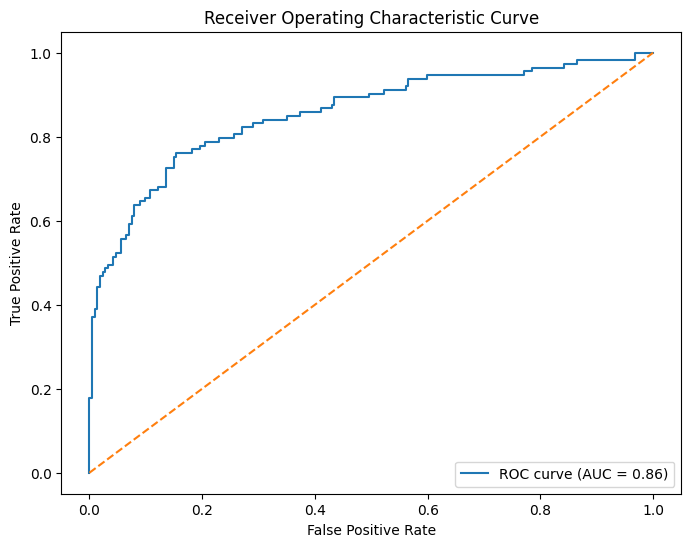

In [30]:
# Evaluation on validation set
y_pred_val = best_model.predict(X_val)
accuracy_val = accuracy_score(y_val, y_pred_val)
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1_val = f1_score(y_val, y_pred_val)
balanced_acc_val = balanced_accuracy_score(y_val, y_pred_val)  # Add balanced accuracy
conf_matrix_val = confusion_matrix(y_val, y_pred_val)

print(f"Validation Accuracy: {accuracy_val}")
print(f"Validation Precision: {precision_val}")
print(f"Validation Recall: {recall_val}")
print(f"Validation F1 Score: {f1_val}")
print(f"Validation Balanced Accuracy: {balanced_acc_val}")  # Print balanced accuracy
print(f"Validation Confusion Matrix: \n{conf_matrix_val}")

# Final evaluation on test set
y_pred_test = best_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
balanced_acc_test = balanced_accuracy_score(y_test, y_pred_test)  # Add balanced accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

print(f"Test Accuracy: {accuracy_test}")
print(f"Test Precision: {precision_test}")
print(f"Test Recall: {recall_test}")
print(f"Test F1 Score: {f1_test}")
print(f"Test Balanced Accuracy: {balanced_acc_test}")  # Print balanced accuracy
print(f"Test Confusion Matrix: \n{conf_matrix_test}")

# Compute ROC AUC
y_prob_test = best_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
roc_auc = roc_auc_score(y_test, y_prob_test)
print(f"Test ROC AUC: {roc_auc}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()

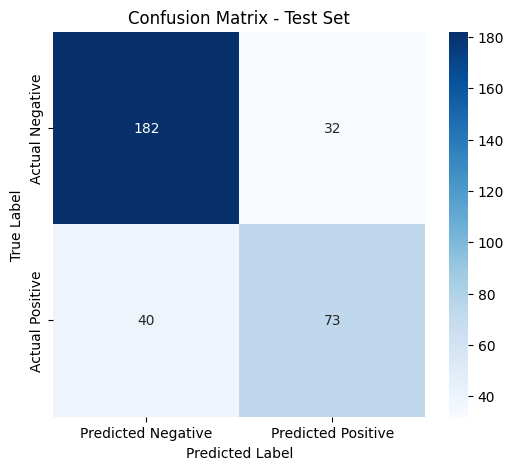

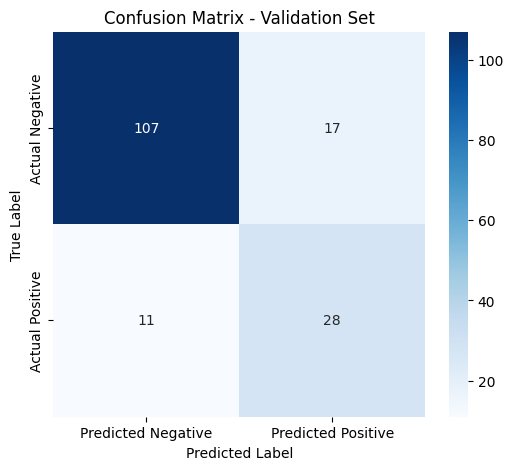

In [72]:
# Plot confusion matrix for test set
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot confusion matrix for validation set
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix - Validation Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Final Training Score: 0.9077
Final Cross-validation Score: 0.8652


/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
1 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/sklear

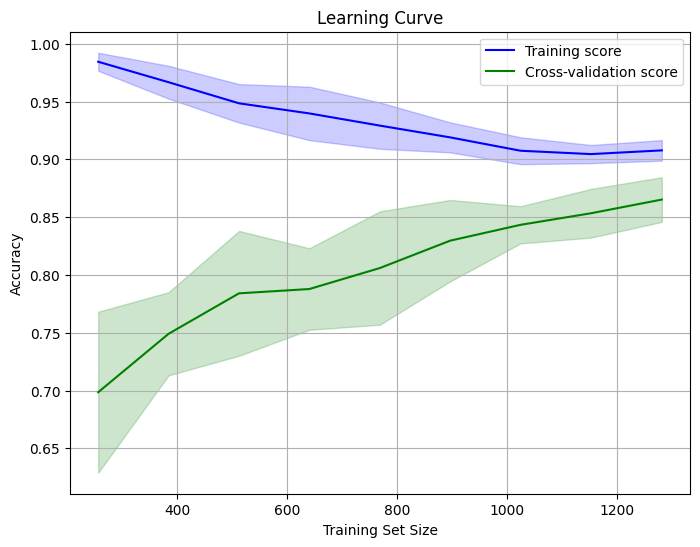

In [73]:
# Using StratifiedKFold for cross-validation
stratified_cv = StratifiedKFold(n_splits=5)

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train_final, y_train_resampled, cv=stratified_cv,  # Use StratifiedKFold
    scoring='accuracy', 
    train_sizes=np.linspace(0.1, 1.0, 10), 
    n_jobs=-1
)

# Calculate the mean and standard deviation of train and test scores
train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)

# Print the final scores (for the largest training set size)
print(f"Final Training Score: {train_scores_mean[-1]:.4f}")
print(f"Final Cross-validation Score: {test_scores_mean[-1]:.4f}")

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='green')

# Fill the area between the curve and the axis to represent the standard deviation
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color='green', alpha=0.2)

# Add labels and title
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()